# Introduction

We'll validate our extraction of mental functions from article texts by comparing the term occurrences to manual annotations of articles in the BrainMap database.


# Load the data

In [1]:
import os
import pandas as pd
import numpy as np

## BrainMap metadata 

In [2]:
df = pd.read_csv("../data/metadata.csv", encoding="latin-1")
df = df.loc[df["SOURCE"] == "BrainMap"]
len(df)

3346

In [3]:
pmids = df["PMID"].astype(int)
df["PMID"] = pmids

In [4]:
df.head(3)

,PMID,DOI,KEY,SOURCE,AUTHORS,YEAR,MONTH,JOURNAL,TITLE,PAGES,VOLUME,ABSTRACT_URL,NUM_COORDINATES,MNI_COORDINATES,BRAINMAP_ID,BEHAVIORAL_DOMAIN,EXPERIMENT,DESCRIPTION
0,1402966,NaN,"Dolan R J, 1992",BrainMap,Dolan R J|Bench C J|Brown R G|Scott L C|Fristo...,1992.0,Sep,"Journal of Neurology, Neurosurgery, and Psychi...",Regional cerebral blood flow abnormalities in ...,768-773,55,http://www.ncbi.nlm.nih.gov/entrez/query.fcgi?...,7.0,"-7.66,51.87,-8.33;-5.51,56.46,-4.28;-5.48,58.9...",6030020.0,"['Action.Rest', 'Action.Rest']","['Unimpaired > Impaired', 'Impaired > Unimpair...",Patients with depression who were cognitively ...
1,1410086,NaN,"Bench C J, 1992",BrainMap,Bench C J|Friston K J|Brown R G|Scott L C|Frac...,1992.0,Aug,Psychological Medicine,The anatomy of melancholia - focal abnormaliti...,607-615,22,http://www.ncbi.nlm.nih.gov/entrez/query.fcgi?...,10.0,"-13.68,29.54,33.76;-15.76,23.53,38.75;-39.5,38...",6030018.0,"['Action.Rest', 'Action.Rest', 'Action.Rest']","['Normals > Depressed', 'Unimpaired > Impaired...",Patients with depression and normal subjects u...
2,1448149,10.1038/360339a0,"Zatorre R J, 1992",BrainMap,Zatorre R J|Jones-Gotman M|Evans A C|Meyer E,1992.0,Nov,Nature,Functional localization and lateralization of ...,339-340,360,http://www.ncbi.nlm.nih.gov/entrez/query.fcgi?...,6.0,"-21.56,5.58,-27.71;22.3,6.36,-21.58;18.98,41.4...",8110311.0,['Perception.Olfaction'],['Odor vs. Odorless'],Subjects underwent 2 conditions in which they ...


## Document-term matrix

In [5]:
dtm = pd.read_csv("../data/text/dtm_190325.csv.gz", 
                  compression="gzip", index_col=0)
dtm = dtm.loc[pmids]
len(dtm)

3346

In [6]:
dtm.head(3)

,2_step,2step,3d_object,abductive_reasoning,aberrant_behavior,aberrant_behavior_checklist,ability,abstinence_syndrome,abstract_analogy,abstract_concrete_task,...,writing_task,yale_global_tic_severity,yale_global_tic_severity_scale,ybocs_total_score,young_mania_rating_scale,youth_drinking,youth_life_stress_interview,zimbardo_time_perspective_inventory,zoo_map_test,zuckerman_sensation_seeking_scale
1402966,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1410086,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1448149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
dtm.max()[:5]

2_step                  2
2step                   5
3d_object              25
abductive_reasoning     0
aberrant_behavior       1
dtype: int64

# Load the BrainMap taxonomy

In [8]:
def process_annotations(annotations):
    annotations = annotations.replace("[", "").replace("]", "")
    annotations = annotations.replace("'", "").replace(" ", "").split(",")
    annotations = [a for a in annotations if "." in a]
    return annotations

## Behavioral subdomains

In [9]:
subdomains = []
for i, row in df.iterrows():
    subdomains += process_annotations(row["BEHAVIORAL_DOMAIN"])     
subdomains = sorted(list(set(subdomains)))
subdomains[:5]

['Action.Execution',
 'Action.Execution.Speech',
 'Action.Imagination',
 'Action.Inhibition',
 'Action.MotorLearning']

## Behavioral domains

In [10]:
domains = sorted(list(set([s.split(".")[0] for s in subdomains])))
domains

['Action',
 'Cognition',
 'Emotion',
 'Interoception',
 'Perception',
 'Pharmacology']

## Behavioral taxonomy

In [11]:
taxonomy = {domain: [s for s in subdomains if s.startswith(domain)] for domain in domains}
taxonomy

{'Action': ['Action.Execution',
  'Action.Execution.Speech',
  'Action.Imagination',
  'Action.Inhibition',
  'Action.MotorLearning',
  'Action.Observation',
  'Action.Preparation',
  'Action.Rest'],
 'Cognition': ['Cognition.Attention',
  'Cognition.Language',
  'Cognition.Language.Orthography',
  'Cognition.Language.Phonology',
  'Cognition.Language.Semantics',
  'Cognition.Language.Speech',
  'Cognition.Language.Syntax',
  'Cognition.Memory',
  'Cognition.Memory.Explicit',
  'Cognition.Memory.Implicit',
  'Cognition.Memory.Working',
  'Cognition.Music',
  'Cognition.Reasoning',
  'Cognition.SocialCognition',
  'Cognition.Somatic',
  'Cognition.Spatial',
  'Cognition.Temporal'],
 'Emotion': ['Emotion.Intensity',
  'Emotion.Negative',
  'Emotion.Negative.Anger',
  'Emotion.Negative.Anxiety',
  'Emotion.Negative.Disgust',
  'Emotion.Negative.Embarrassment',
  'Emotion.Negative.Fear',
  'Emotion.Negative.Guilt',
  'Emotion.Negative.Punishment/Loss',
  'Emotion.Negative.Sadness',
  'Emot

# Load the BrainMap annotations

In [12]:
dam = pd.DataFrame(0, index=pmids, columns=subdomains)
for pmid in pmids:
    annotations = process_annotations(df.loc[df["PMID"] == pmid, "BEHAVIORAL_DOMAIN"].values[0])
    for subdomain in annotations:
        dam.loc[pmid, subdomain] = dam.loc[pmid, subdomain] + 1
dam.head()

,Action.Execution,Action.Execution.Speech,Action.Imagination,Action.Inhibition,Action.MotorLearning,Action.Observation,Action.Preparation,Action.Rest,Cognition.Attention,Cognition.Language,...,Pharmacology.Caffeine,Pharmacology.Capsaicin,Pharmacology.Cocaine,Pharmacology.Marijuana,Pharmacology.Nicotine,Pharmacology.Non-SteroidalAnti-InflammatoryDrugs,Pharmacology.Opioids,Pharmacology.PsychiatricMedications,Pharmacology.PsychiatricMedications.Antidepressants,Pharmacology.SteroidsandHormones.Estrogen
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1410086,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1448149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Reweight by TF-IDF

In [13]:
def tfidf(df):
    
    # Rows are documents, columns are terms
    # Inverse document frequencies
    doccount = float(df.shape[0])
    freqs = df.astype(bool).sum(axis=0)
    idfs = np.log(doccount / freqs)
    idfs[np.isinf(idfs)] = 0.0  # log(0) = 0
    
    # Term frequencies
    terms_in_doc = df.sum(axis=1)
    tfs = (df.T / terms_in_doc).T
    
    # TF-IDF reweighting
    X = tfs * idfs
    
    # Fill NA with 0
    X = X.fillna(0.0)
    
    return X

In [14]:
dtm_tfidf = tfidf(dtm)
dam_tfidf = tfidf(dam)

In [15]:
dtm_tfidf.head(3)

,2_step,2step,3d_object,abductive_reasoning,aberrant_behavior,aberrant_behavior_checklist,ability,abstinence_syndrome,abstract_analogy,abstract_concrete_task,...,writing_task,yale_global_tic_severity,yale_global_tic_severity_scale,ybocs_total_score,young_mania_rating_scale,youth_drinking,youth_life_stress_interview,zimbardo_time_perspective_inventory,zoo_map_test,zuckerman_sensation_seeking_scale
1402966,0.0,0.0,0.0,0.0,0.0,0.0,0.002921,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1410086,0.0,0.0,0.0,0.0,0.0,0.0,0.002322,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1448149,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Associate terms with domains

In [16]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

## Drop terms that never occurred

In [17]:
dtm_tfidf = dtm_tfidf.loc[:, (dtm_tfidf != 0).any(axis=0)]
dtm_tfidf.shape

(3346, 3172)

## Drop subdomains annotating < 100 articles

In [18]:
subdomains = [subdomain for subdomain in subdomains if dam[subdomain].astype(bool).sum() > 0]
subdomains

['Action.Execution',
 'Action.Execution.Speech',
 'Action.Imagination',
 'Action.Inhibition',
 'Action.MotorLearning',
 'Action.Observation',
 'Action.Preparation',
 'Action.Rest',
 'Cognition.Attention',
 'Cognition.Language',
 'Cognition.Language.Orthography',
 'Cognition.Language.Phonology',
 'Cognition.Language.Semantics',
 'Cognition.Language.Speech',
 'Cognition.Language.Syntax',
 'Cognition.Memory',
 'Cognition.Memory.Explicit',
 'Cognition.Memory.Implicit',
 'Cognition.Memory.Working',
 'Cognition.Music',
 'Cognition.Reasoning',
 'Cognition.SocialCognition',
 'Cognition.Somatic',
 'Cognition.Spatial',
 'Cognition.Temporal',
 'Emotion.Intensity',
 'Emotion.Negative',
 'Emotion.Negative.Anger',
 'Emotion.Negative.Anxiety',
 'Emotion.Negative.Disgust',
 'Emotion.Negative.Embarrassment',
 'Emotion.Negative.Fear',
 'Emotion.Negative.Guilt',
 'Emotion.Negative.Punishment/Loss',
 'Emotion.Negative.Sadness',
 'Emotion.Neutral',
 'Emotion.Other',
 'Emotion.Positive',
 'Emotion.Positive.

In [19]:
domains = sorted(list(set([s.split(".")[0] for s in subdomains])))
domains

['Action',
 'Cognition',
 'Emotion',
 'Interoception',
 'Perception',
 'Pharmacology']

## Compute associations and FDRs

In [20]:
r_file = "data/domains_terms_r.csv"
p_file = "data/domains_terms_p.csv"
fdr_file = "data/domains_terms_fdr.csv"

if not os.path.exists(r_file) or not os.path.exists(p_file) or not os.path.exists(fdr_file):
    terms = list(dtm_tfidf.columns)
    r = pd.DataFrame(index=terms, columns=subdomains)
    p = pd.DataFrame(index=terms, columns=subdomains)
    fdr = pd.DataFrame(index=terms, columns=subdomains)

    for subdomain in subdomains:
        print("Processing {}".format(subdomain))
        for term in terms:
            rtest = pearsonr(dtm_tfidf[term], dam_tfidf[subdomain])
            r.loc[term, subdomain] = rtest[0]
            p.loc[term, subdomain] = rtest[1]
        fdr[subdomain] = multipletests(p[subdomain], method="fdr_bh")[1]

    r.to_csv(r_file)
    p.to_csv(p_file)
    fdr.to_csv(fdr_file)
    
else:
    r = pd.read_csv(r_file, index_col=0)
    p = pd.read_csv(p_file, index_col=0)
    fdr = pd.read_csv(fdr_file, index_col=0)

In [21]:
r["Action.Execution"].sort_values(ascending=False)[:10]

movement          0.608254
motor             0.575089
sensorimotor      0.484687
motor_control     0.317032
hand              0.310318
execution         0.289838
arm               0.281449
finger_tapping    0.258947
swallowing        0.250867
coordination      0.238535
Name: Action.Execution, dtype: float64

## Threshold associations (r > 0, FDR < 0.001)

In [22]:
r_thres = r
r_thres[r_thres < 0] = 0
r_thres[fdr > 0.001] = 0
r_thres.head()

,Action.Execution,Action.Execution.Speech,Action.Imagination,Action.Inhibition,Action.MotorLearning,Action.Observation,Action.Preparation,Action.Rest,Cognition.Attention,Cognition.Language,...,Pharmacology.Caffeine,Pharmacology.Capsaicin,Pharmacology.Cocaine,Pharmacology.Marijuana,Pharmacology.Nicotine,Pharmacology.Non-SteroidalAnti-InflammatoryDrugs,Pharmacology.Opioids,Pharmacology.PsychiatricMedications,Pharmacology.PsychiatricMedications.Antidepressants,Pharmacology.SteroidsandHormones.Estrogen
2_step,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2step,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3d_object,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aberrant_behavior,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aberrant_behavior_checklist,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Plot word clouds

In [26]:
%matplotlib inline

In [27]:
# Hex color mappings
c = {"red": "#CE7D69", "orange": "#BA7E39", "yellow": "#CEBE6D", 
     "chartreuse": "#AEC87C", "green": "#77B58A", "blue": "#7597D0", 
     "magenta": "#B07EB6", "purple": "#7D74A3", "brown": "#846B43", "pink": "#CF7593"}

# Palette for framework
palette = [c["red"], c["green"], c["blue"], c["yellow"], c["purple"], c["orange"]]
colors = []
for i, domain in enumerate(domains):
    colors += [palette[i]] * len([s for s in taxonomy[domain] if s in subdomains])
len(colors) == len(subdomains)

True

In [28]:
def plot_wordclouds(df, path="", prefix="", font="../style/Arial Unicode.ttf", 
                    print_fig=True, width=550):

    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    df.index = [term.replace("_", " ") for term in df.index]
    
    for i, title in enumerate(df.columns):

        def color_func(word, font_size, position, orientation, 
                       random_state=None, idx=0, **kwargs):

            # Adapted from https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html

            return colors[i]

        title_df = df.loc[df[title] > 0, title]
        tkn2freq = {t: f for t, f in zip(title_df.index, title_df.values)}

        cloud = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGB", 
                          max_font_size=100, prefer_horizontal=1, scale=20, margin=3,
                          width=width, height=width, font_path=font, 
                          random_state=42).generate_from_frequencies(frequencies=tkn2freq)

        fig = plt.figure()
        plt.axis("off")
        plt.imshow(cloud.recolor(color_func=color_func, random_state=42))
        
        file_name = "{}wordcloud/{}{}.png".format(path, prefix, title.replace("/", ""))
        plt.savefig(file_name, dpi=500, bbox_inches="tight")
        
        if print_fig:
            print(title)
            plt.show()
        plt.close()

Action.Execution


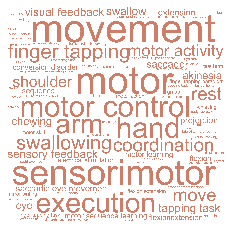

Action.Execution.Speech


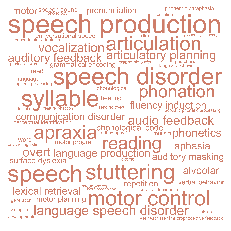

Action.Imagination


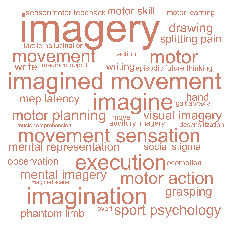

Action.Inhibition


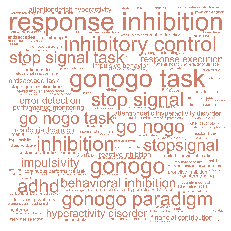

Action.MotorLearning


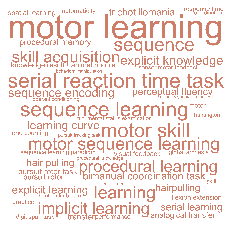

Action.Observation


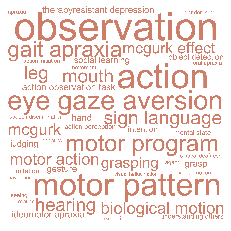

Action.Preparation


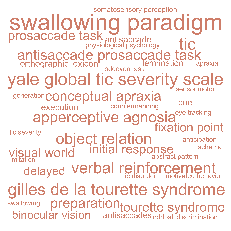

Action.Rest


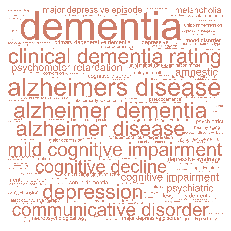

Cognition.Attention


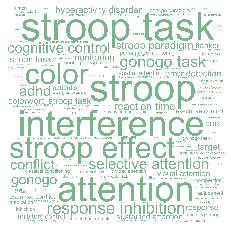

Cognition.Language


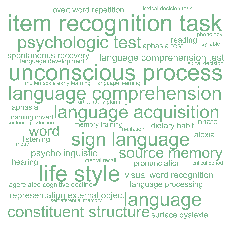

Cognition.Language.Orthography


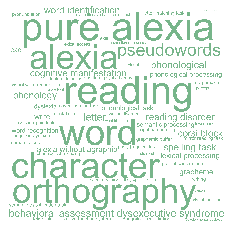

Cognition.Language.Phonology


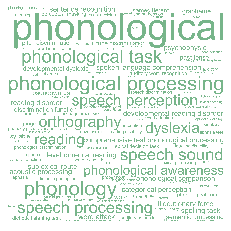

Cognition.Language.Semantics


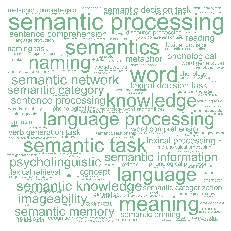

Cognition.Language.Speech


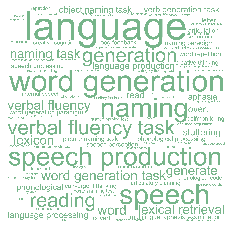

Cognition.Language.Syntax


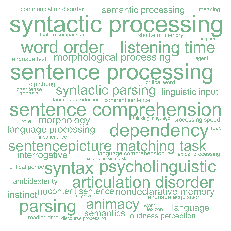

Cognition.Memory


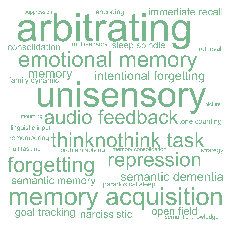

Cognition.Memory.Explicit


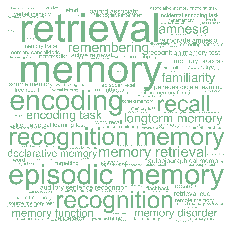

Cognition.Memory.Implicit


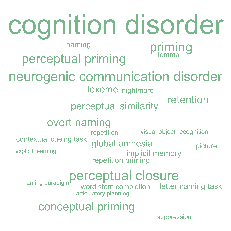

Cognition.Memory.Working


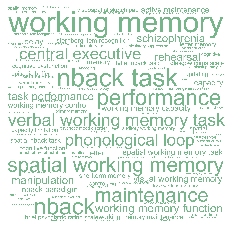

Cognition.Music


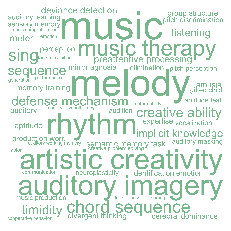

Cognition.Reasoning


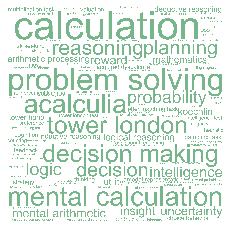

Cognition.SocialCognition


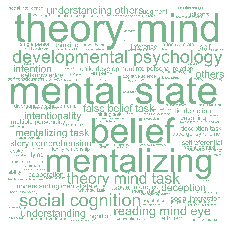

Cognition.Somatic


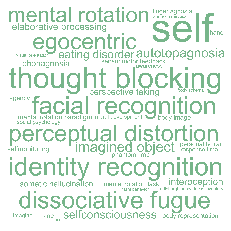

Cognition.Spatial


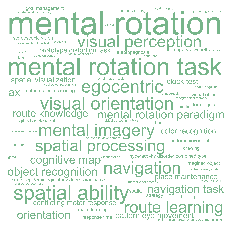

Cognition.Temporal


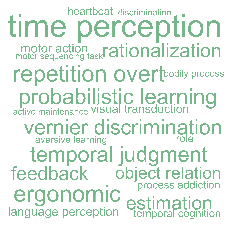

Emotion.Intensity


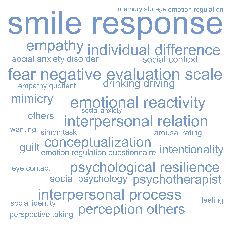

Emotion.Negative


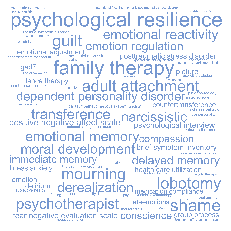

Emotion.Negative.Anger


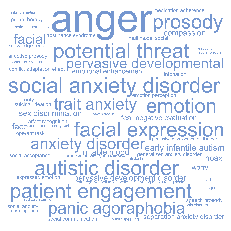

Emotion.Negative.Anxiety


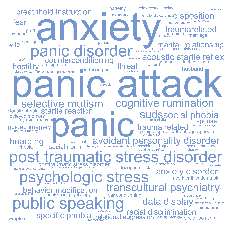

Emotion.Negative.Disgust


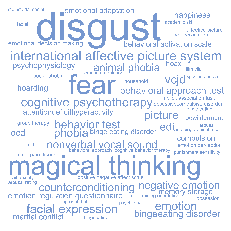

Emotion.Negative.Embarrassment


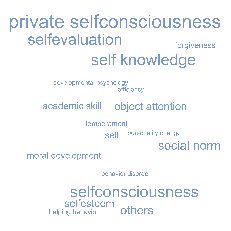

Emotion.Negative.Fear


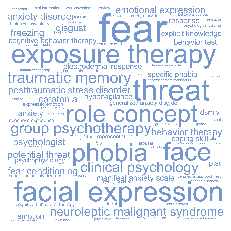

Emotion.Negative.Guilt


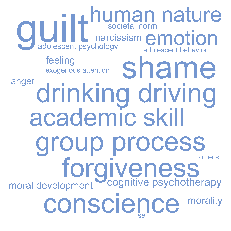

Emotion.Negative.Punishment/Loss


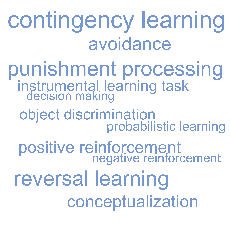

Emotion.Negative.Sadness


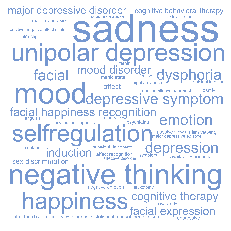

Emotion.Neutral


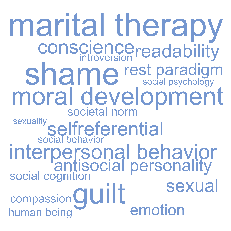

Emotion.Other


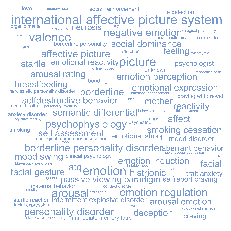

Emotion.Positive


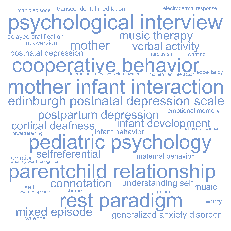

Emotion.Positive.Happiness


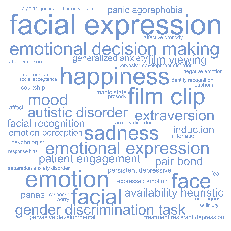

Emotion.Positive.Happiness.Humor


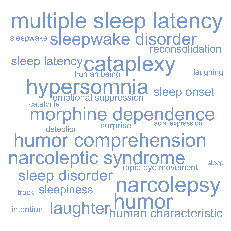

Emotion.Positive.Reward/Gain


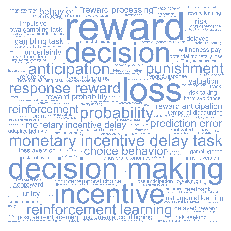

Emotion.Valence


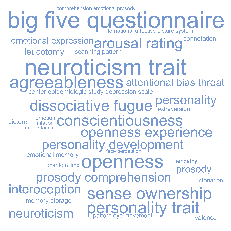

Interoception.Baroregulation


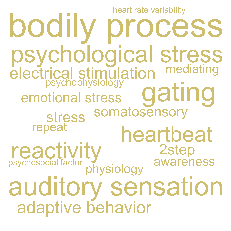

Interoception.Gastrointestinal/Genitourinary(GI/GU)


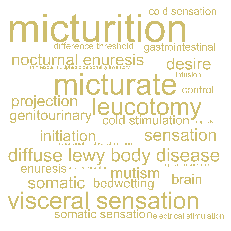

Interoception.HeartbeatDetection


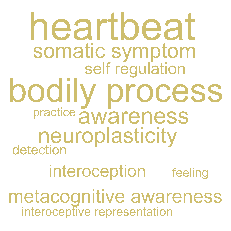

Interoception.Hunger


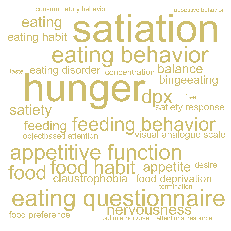

Interoception.Osmoregulation


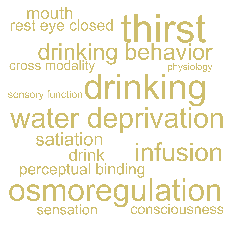

Interoception.RespirationRegulation


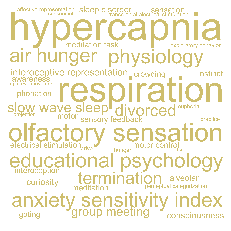

Interoception.Sexuality


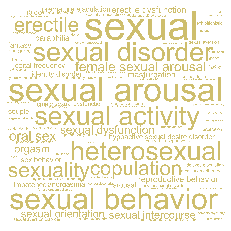

Interoception.Sleep


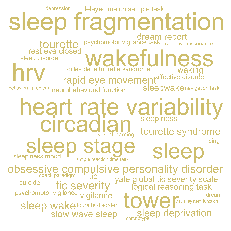

Interoception.Thermoregulation


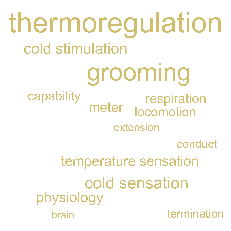

Interoception.Thirst


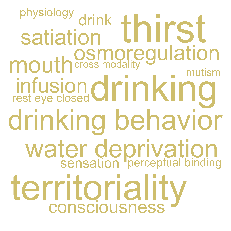

Interoception.Vestibular


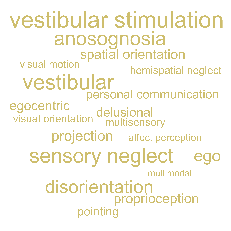

Perception.Audition


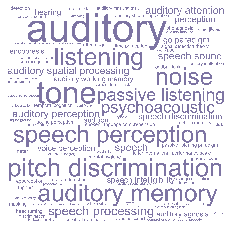

Perception.Gustation


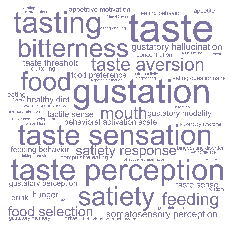

Perception.Olfaction


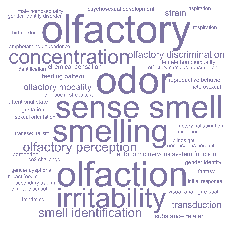

Perception.Somesthesis


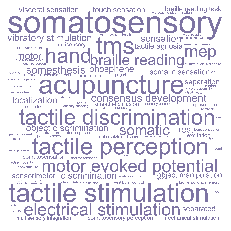

Perception.Somesthesis.Pain


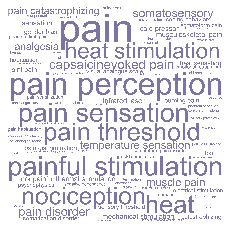

Perception.Vision


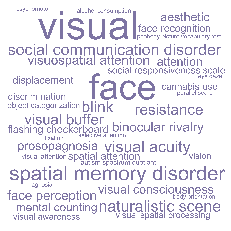

Perception.Vision.Color


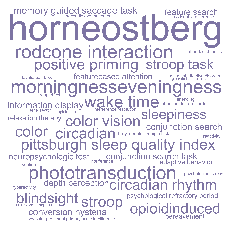

Perception.Vision.Motion


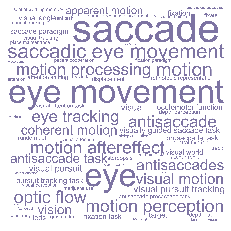

Perception.Vision.Shape


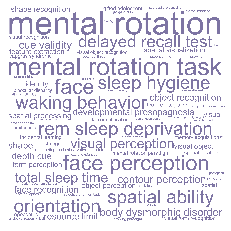

Pharmacology.Alcohol


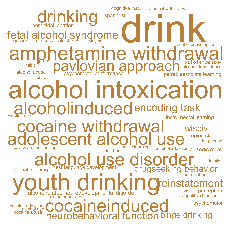

Pharmacology.Amphetamines.Methamphetamine


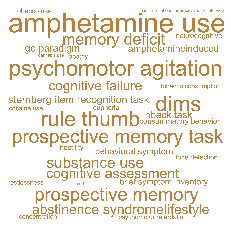

Pharmacology.Caffeine


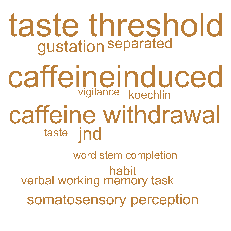

Pharmacology.Capsaicin


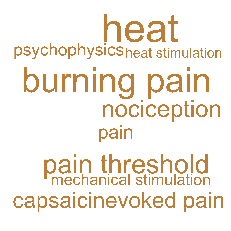

Pharmacology.Cocaine


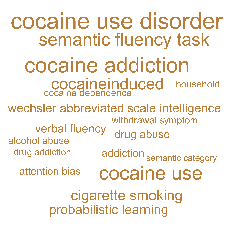

Pharmacology.Marijuana


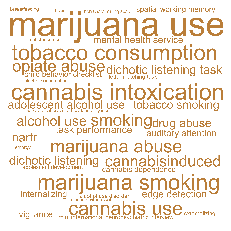

Pharmacology.Nicotine


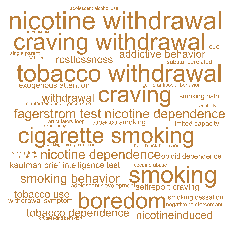

Pharmacology.Non-SteroidalAnti-InflammatoryDrugs


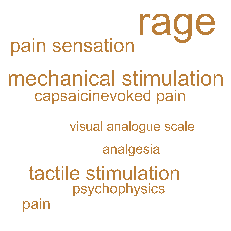

Pharmacology.Opioids


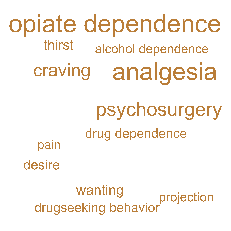

Pharmacology.PsychiatricMedications


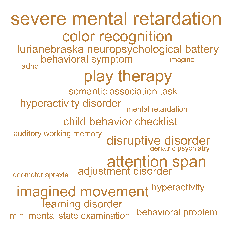

Pharmacology.PsychiatricMedications.Antidepressants


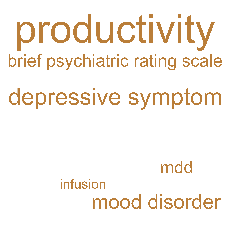

Pharmacology.SteroidsandHormones.Estrogen


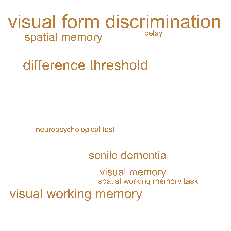

In [29]:
plot_wordclouds(r_thres, path="figures/brainmap/")